In [5]:
# This notebook identifies a golfball in radar data
# range_doppler_notebook has the basics of how to get the basics

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum
from cfar import cfar, clean_cfar
from radar_functions import range_doppler_map, get_measurement_parameters, cfar_map, save_range_doppler_map

c = 299792458 # metres per second - need this

In [6]:
# Making data lists
moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')

preface = '../4022S_data/golfball_testset1/'

# There is CERTAINLY a way to do this faster but I dont have internet rn so oh well :/
# TODO: Find the right thing to do this
initial_slow_tests = [h5py.File(f'{preface}Experiment_2024-09-13_14-13-34_932_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-00_080_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-17_789_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-35_509_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-50_154_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-15-40_120_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-15-55_306_initialgolftest_slow.hdf5','r')]

initial_fast_tests = [h5py.File(f'{preface}Experiment_2024-09-13_14-17-13_795_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-01_884_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-18_495_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-35_886_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-20_774_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-34_102_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-47_106_initialgolftest_fast.hdf5'),]


c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks


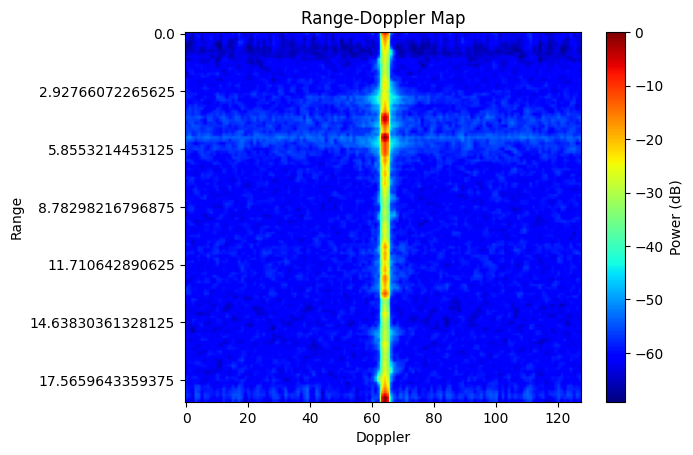

In [7]:
test_in_question = initial_slow_tests[3]
freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size = get_measurement_parameters(test_in_question)
range_doppler_data = range_doppler_map(test_in_question, '9', range_bin_size, True)
#cfar_data = cfar_map(range_doppler_data, 1)

c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks


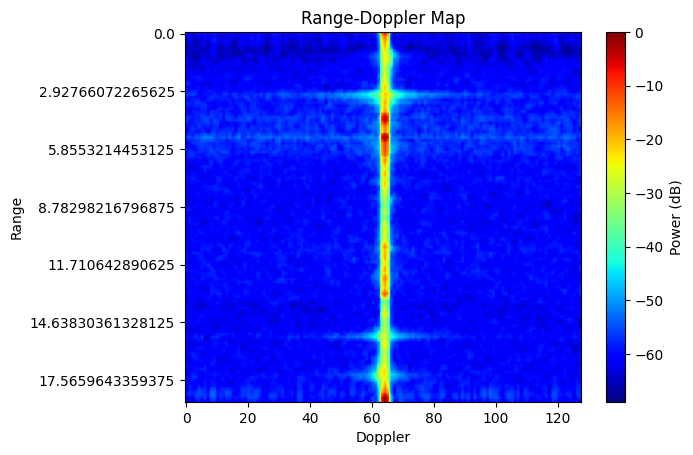

In [8]:
# Need to take all frames of a target and generate all the maps
i = 0
while True:
    try:
        map = range_doppler_map(test_in_question, i, range_bin_size, False)
        save_range_doppler_map(map, range_bin_size,f'test frame {i}')
        i+=1
    except: 
        break
    